<a href="https://colab.research.google.com/github/solharsh/All_Neural_Networks/blob/master/understanding_text_Classification_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification with an RNN

In [1]:
!pip install -q tf-nightly
import tensorflow_datasets as tfds
import tensorflow as tf

     |████████████████████████████████| 522.4MB 29kB/s 
     |████████████████████████████████| 3.0MB 47.7MB/s 
     |████████████████████████████████| 460kB 42.9MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 


Import `matplotlib` and create a helper function to plot graphs:


In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

The IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment.

Download the dataset using TFDS.

In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete0XR07P/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete0XR07P/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete0XR07P/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


 The dataset `info` includes the encoder (a `tfds.features.text.SubwordTextEncoder`).

In [0]:
encoder = info.features['text'].encoder

In [5]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [6]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [0]:
assert original_string == sample_string

In [8]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## Prepare the data for training

Next create batches of these encoded strings. Use the `padded_batch` method to zero-pad the sequences to the length of the longest string in the batch:

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE, padded_shapes=([None],[])))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE,  padded_shapes=([None],[])))

In [0]:
#Note: As of TensorFlow 2.2 the padded_shapes argument is no longer required. The default behavior is to pad all axes to the longest in the batch.
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE))

## Create the model

Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. 

Compile the Keras model to configure the training process:

In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [14]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 827s 2s/step - loss: 0.6226 - accuracy: 0.5851 - val_loss: 0.4265 - val_accuracy: 0.8047
Epoch 2/10
391/391 [==============================] - 821s 2s/step - loss: 0.3265 - accuracy: 0.8649 - val_loss: 0.3322 - val_accuracy: 0.8568
Epoch 3/10
391/391 [==============================] - 837s 2s/step - loss: 0.2477 - accuracy: 0.9045 - val_loss: 0.3287 - val_accuracy: 0.8531
Epoch 4/10
391/391 [==============================] - 828s 2s/step - loss: 0.2070 - accuracy: 0.9231 - val_loss: 0.3220 - val_accuracy: 0.8693
Epoch 5/10
391/391 [==============================] - 830s 2s/step - loss: 0.1788 - accuracy: 0.9378 - val_loss: 0.3510 - val_accuracy: 0.8740
Epoch 6/10
391/391 [==============================] - 815s 2s/step - loss: 0.1651 - accuracy: 0.9411 - val_loss: 0.3798 - val_accuracy: 0.8750
Epoch 7/10
391/391 [==============================] - 825s 2s/step - loss: 0.1439 - accuracy: 0.9502 - val_loss: 0.3816 - val_accuracy: 0.8667

In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 181s 464ms/step - loss: 0.4505 - accuracy: 0.8591
Test Loss: 0.45051515102386475
Test Accuracy: 0.8590800166130066


The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would [use masking](../../guide/keras/masking_and_padding) to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [0]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = mode    l.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [18]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.45780197]]


In [19]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.39246526]]


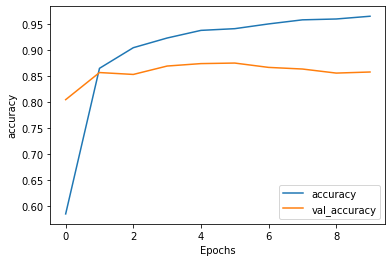

In [20]:
plot_graphs(history, 'accuracy')

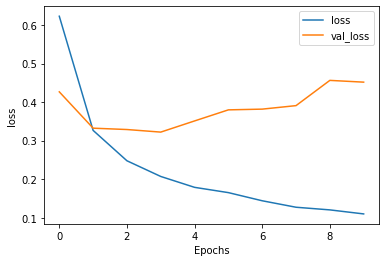

In [21]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1494s 4s/step - loss: 0.6869 - accuracy: 0.5062 - val_loss: 0.5964 - val_accuracy: 0.6406
Epoch 2/10
391/391 [==============================] - 1523s 4s/step - loss: 0.4192 - accuracy: 0.8131 - val_loss: 0.3603 - val_accuracy: 0.8536
Epoch 3/10
391/391 [==============================] - 1527s 4s/step - loss: 0.2821 - accuracy: 0.8954 - val_loss: 0.3674 - val_accuracy: 0.8583
Epoch 4/10
391/391 [==============================] - 1515s 4s/step - loss: 0.2293 - accuracy: 0.9196 - val_loss: 0.3463 - val_accuracy: 0.8703
Epoch 5/10
391/391 [==============================] - 1509s 4s/step - loss: 0.1914 - accuracy: 0.9366 - val_loss: 0.3670 - val_accuracy: 0.8594
Epoch 6/10
391/391 [==============================] - 1505s 4s/step - loss: 0.1749 - accuracy: 0.9444 - val_loss: 0.4007 - val_accuracy: 0.8672
Epoch 7/10
391/391 [==============================] - 1537s 4s/step - loss: 0.1436 - accuracy: 0.9594 - val_loss: 0.4103 - val_accuracy:

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 324s 829ms/step - loss: 0.5334 - accuracy: 0.8445
Test Loss: 0.53340083360672
Test Accuracy: 0.8445199728012085


In [26]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-2.0208414]]


In [27]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-2.3249767]]


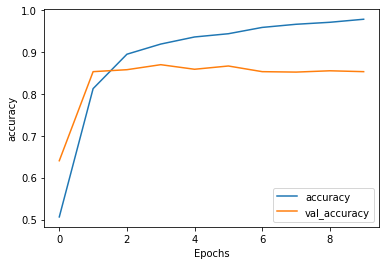

In [28]:
plot_graphs(history, 'accuracy')

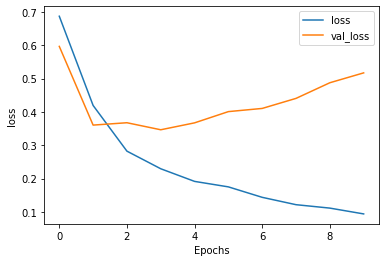

In [29]:
plot_graphs(history, 'loss')